In [1]:
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from superfv import (
    EulerSolver,
    OutputLoader,
    plot_1d_slice,
)
from superfv.initial_conditions import square

In [2]:
N = 64
T = 1.0
gamma = 1.4

base = "../out/hydro_advection_2d_square_varying_rho_min/"
overwrite = []

PAD = {"rho": (0, None), "P": (0, None)}

configs = {
    "MUSCL-Hancock": dict(p=1, MUSCL=True, MUSCL_limiter="PP2D"),
    "ZS3": dict(p=3, ZS=True, GL=True, lazy_primitives="adaptive", PAD=PAD),
    "ZS3t": dict(p=3, ZS=True, adaptive_dt=False, lazy_primitives="adaptive", PAD=PAD),
    "MM3": dict(p=3, MOOD=True, lazy_primitives="adaptive", PAD=PAD),
    "MM3b": dict(p=3, MOOD=True, blend=True, lazy_primitives="adaptive", PAD=PAD),
    "MM3-wp": dict(p=3, MOOD=True, lazy_primitives="none", PAD=PAD),
    # "ZS7": dict(p=7, ZS=True, GL=True, lazy_primitives="adaptive", PAD=PAD),
    # "ZS7t": dict(p=7, ZS=True, adaptive_dt=False, lazy_primitives="adaptive", PAD=PAD),
    # "MM7": dict(p=7, MOOD=True, lazy_primitives="adaptive", PAD=PAD),
    # "MM7b": dict(p=7, MOOD=True, blend=True, lazy_primitives="adaptive", PAD=PAD),
}

sims = {}
data = []
for (name, config), rho_min in product(
    configs.items(), [1e-1, 1e-2, 1e-3, 1e-4, 1e-6, 1e-8]
):
    path = base + name + f"/rho_min_{rho_min:.0e}/"
    if overwrite != "all":
        if name not in overwrite:
            try:
                # sim = OutputLoader(path)
                # sims[name] = sim
                with open(path + "status.txt", "r") as f:
                    status = f.read().strip()
                data.append(
                    dict(
                        name=name,
                        rho_min=rho_min,
                        passed={"passed": True, "failed": False}.get(status, None),
                    )
                )

                print(f'Read status from "{path}"')
                continue
            except FileNotFoundError:
                pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=partial(square, vx=2, vy=1, bounds=(rho_min, 1.0), P=1e-5),
        gamma=gamma,
        nx=N,
        ny=N,
        cupy=True,
        **config,
    )

    try:
        sim.run(T, allow_overshoot=True, path=path, overwrite=True)
        sims[name] = sim
        with open(path + "status.txt", "w") as f:
            f.write("passed")
        data.append(dict(name=name, rho_min=rho_min, passed=True))
    except Exception as e:
        print(f"Failed: {e}")
        with open(path + "status.txt", "w") as f:
            f.write("failed")
        data.append(dict(name=name, rho_min=rho_min, passed=False))
        continue
df = pd.DataFrame(data)

Read status from "../out/hydro_advection_2d_square_varying_rho_min/MUSCL-Hancock/rho_min_1e-01/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/MUSCL-Hancock/rho_min_1e-02/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/MUSCL-Hancock/rho_min_1e-03/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/MUSCL-Hancock/rho_min_1e-04/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/MUSCL-Hancock/rho_min_1e-06/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/MUSCL-Hancock/rho_min_1e-08/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-01/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-02/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-03/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-04/"
Read status from "../out/hydro_advection_2d_square_varying_rho_min/ZS3

In [3]:
df

,name,rho_min,passed
0,MUSCL-Hancock,1.000000e-01,True
1,MUSCL-Hancock,1.000000e-02,True
2,MUSCL-Hancock,1.000000e-03,True
3,MUSCL-Hancock,1.000000e-04,True
4,MUSCL-Hancock,1.000000e-06,True
5,MUSCL-Hancock,1.000000e-08,True
6,ZS3,1.000000e-01,True
7,ZS3,1.000000e-02,True
8,ZS3,1.000000e-03,True
9,ZS3,1.000000e-04,True


In [4]:
df.pivot(index="rho_min", columns="name", values="passed").loc[
    :,
    ["MUSCL-Hancock", "ZS3", "ZS3t", "MM3-wp", "MM3", "MM3b"],
].sort_index(ascending=False)

name,MUSCL-Hancock,ZS3,ZS3t,MM3-wp,MM3,MM3b
rho_min,,,,,,
1.000000e-01,True,True,True,True,True,True
1.000000e-02,True,True,True,True,True,True
1.000000e-03,True,True,False,True,True,True
1.000000e-04,True,True,False,True,True,True
1.000000e-06,True,True,False,False,True,True
1.000000e-08,True,True,False,False,False,False


Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MUSCL-Hancock/rho_min_1e-06"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-06"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-06"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-06"


/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(


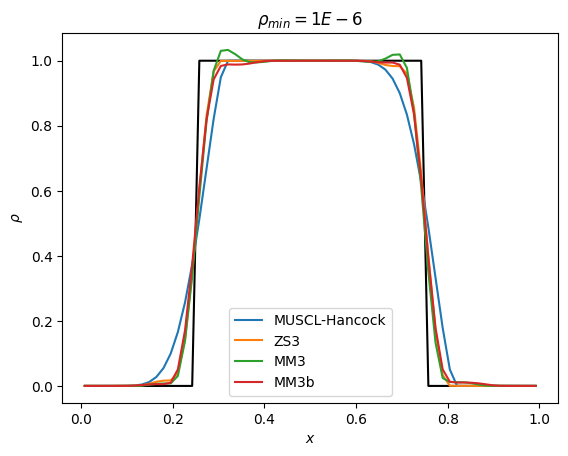

In [10]:
fig, ax = plt.subplots()
ax.set_title(r"$\rho_{min}=1E-6$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\rho$")

sim0 = OutputLoader(base + "/MUSCL-Hancock/rho_min_1e-06")
sim1 = OutputLoader(base + "/ZS3/rho_min_1e-06")
sim2 = OutputLoader(base + "/MM3/rho_min_1e-06")
sim3 = OutputLoader(base + "/MM3b/rho_min_1e-06")

plot_1d_slice(sim0, ax, "rho", y=0.5, cell_averaged=True, t=0, color="k")

plot_1d_slice(sim0, ax, "rho", y=0.5, cell_averaged=True, label="MUSCL-Hancock")
plot_1d_slice(sim1, ax, "rho", y=0.5, cell_averaged=True, label="ZS3")
plot_1d_slice(sim2, ax, "rho", y=0.5, cell_averaged=True, label="MM3")
plot_1d_slice(sim3, ax, "rho", y=0.5, cell_averaged=True, label="MM3b")

ax.legend()

Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-02"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-03"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-04"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-06"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-08"


/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(


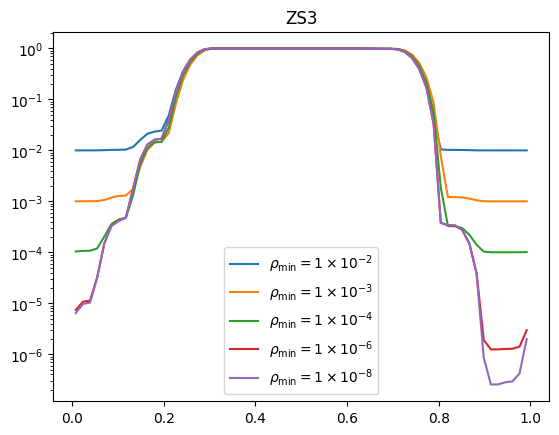

In [6]:
fig, ax = plt.subplots()
ax.set_title("ZS3")
ax.set_yscale("log")

sim1 = OutputLoader(base + "/ZS3/rho_min_1e-02")
sim2 = OutputLoader(base + "/ZS3/rho_min_1e-03")
sim3 = OutputLoader(base + "/ZS3/rho_min_1e-04")
sim4 = OutputLoader(base + "/ZS3/rho_min_1e-06")
sim5 = OutputLoader(base + "/ZS3/rho_min_1e-08")

plot_1d_slice(
    sim1,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-2}$",
)
plot_1d_slice(
    sim2,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-3}$",
)
plot_1d_slice(
    sim3,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-4}$",
)
plot_1d_slice(
    sim4,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-6}$",
)
plot_1d_slice(
    sim5,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-8}$",
)

ax.legend()

Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-02"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-03"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-04"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-06"


/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(


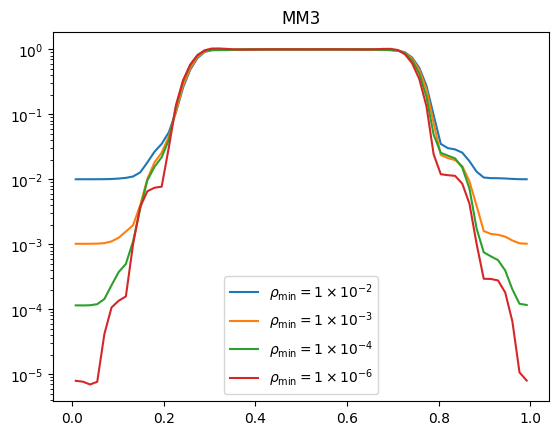

In [7]:
fig, ax = plt.subplots()
ax.set_title("MM3")
ax.set_yscale("log")

sim1 = OutputLoader(base + "/MM3/rho_min_1e-02")
sim2 = OutputLoader(base + "/MM3/rho_min_1e-03")
sim3 = OutputLoader(base + "/MM3/rho_min_1e-04")
sim4 = OutputLoader(base + "/MM3/rho_min_1e-06")

plot_1d_slice(
    sim1,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-2}$",
)
plot_1d_slice(
    sim2,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-3}$",
)
plot_1d_slice(
    sim3,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-4}$",
)
plot_1d_slice(
    sim4,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-6}$",
)

ax.legend()

Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-02"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-03"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-04"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-06"


/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(


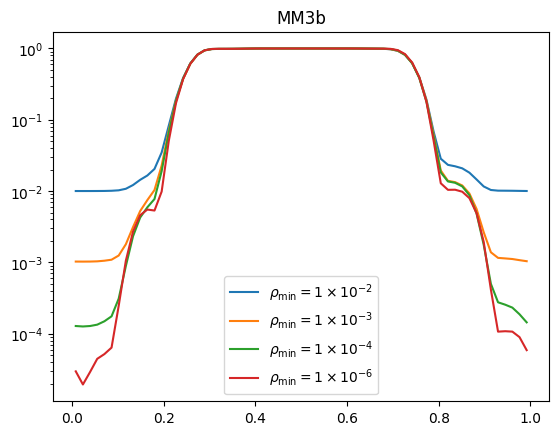

In [8]:
fig, ax = plt.subplots()
ax.set_title("MM3b")
ax.set_yscale("log")

sim1 = OutputLoader(base + "/MM3b/rho_min_1e-02")
sim2 = OutputLoader(base + "/MM3b/rho_min_1e-03")
sim3 = OutputLoader(base + "/MM3b/rho_min_1e-04")
sim4 = OutputLoader(base + "/MM3b/rho_min_1e-06")

plot_1d_slice(
    sim1,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-2}$",
)
plot_1d_slice(
    sim2,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-3}$",
)
plot_1d_slice(
    sim3,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-4}$",
)
plot_1d_slice(
    sim4,
    ax,
    "rho",
    y=0.5,
    cell_averaged=True,
    label=r"$\rho_{\min} = 1 \times 10^{-6}$",
)

ax.legend()

Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-02"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3t/rho_min_1e-02"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-02"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-02"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-03"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-03"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-03"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-04"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-04"


/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; usi

Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-04"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-06"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3/rho_min_1e-06"
Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/MM3b/rho_min_1e-06"


/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(


Successfully read simulation output from "../out/hydro_advection_2d_square_varying_rho_min/ZS3/rho_min_1e-08"


/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(


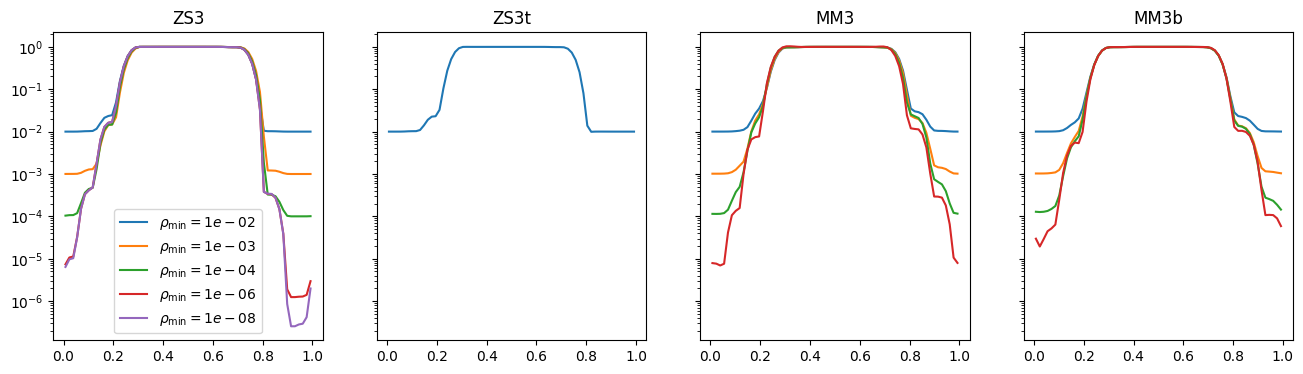

In [ ]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 4))
axs[0].set_title("ZS3")
axs[1].set_title("ZS3t")
axs[2].set_title("MM3")
axs[3].set_title("MM3b")
axs[0].set_yscale("log")

for rho_min in [1e-2, 1e-3, 1e-4, 1e-6, 1e-8]:
    for i, scheme in enumerate(["ZS3", "ZS3t", "MM3", "MM3b"]):
        try:
            sim = OutputLoader(base + f"/{scheme}/rho_min_{rho_min:.0e}/")
            plot_1d_slice(
                sim,
                axs[i],
                "rho",
                y=0.5,
                cell_averaged=True,
                label=rf"$\rho_{{\min}} = {rho_min:.0e}$",
            )
        except Exception as e:
            print(f"Error loading simulation data for {scheme} with {rho_min}: {e}")
            continue

axs[0].legend()